# MNIST Digit Classification using Convolutional Neural Networks 
**Author:** George Kumi Acheampong  
**Date:** January 2026  
**Objective:** Build a production-ready CNN for handwritten digit recognition achieving ~99% accuracy
# Table of Contents
1. [Setup & Imports](#setup)
2. [Data Loading & Exploration](#data)
3. [Model Architecture](#model)
4. [Training](#training)
5. [Evaluation & Visualization](#evaluation)

# 1. Setup & Imports


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from typing import Tuple
import logging

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


# 2. Data Loading & Exploration
# The MNIST dataset contains 70,000 grayscale images of handwritten digits (0-9):
- Training set: 60,000 images
- Test set: 10,000 images
- Image size: 28×28 pixels

In [4]:
# Load MNIST dataset
logger.info("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Image shape: {X_train.shape[1:]} (height × width)")
print(f"Pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"Number of classes: {len(np.unique(y_train))}")

2026-01-05 16:09:28,805 - INFO - Loading MNIST dataset...


Training samples: 60,000
Test samples: 10,000
Image shape: (28, 28) (height × width)
Pixel value range: [0, 255]
Number of classes: 10


# Visualize Sample Images


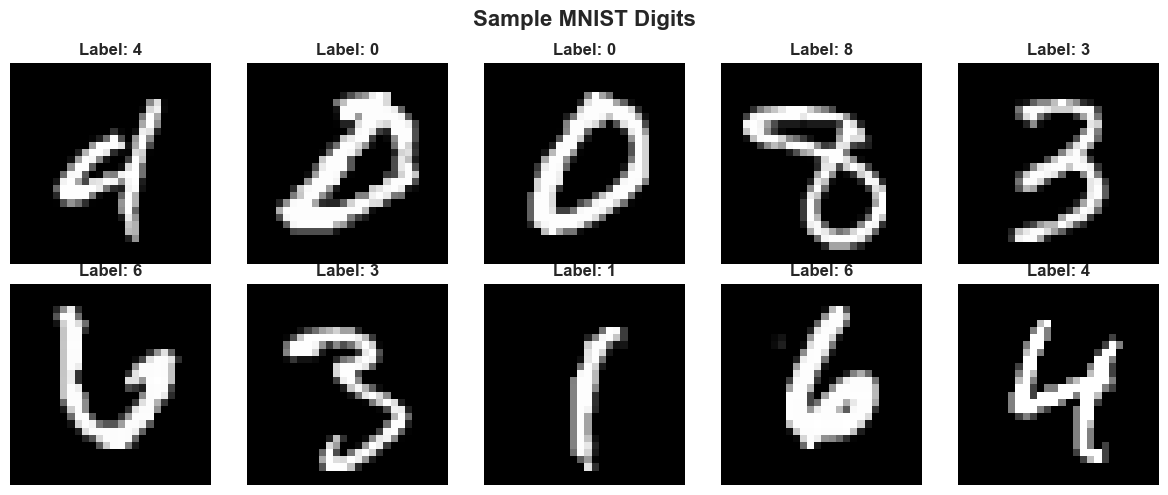

In [5]:
# Display random samples from training set
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    random_idx = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[random_idx], cmap='gray')
    axes[i].set_title(f'Label: {y_train[random_idx]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample MNIST Digits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


#  Class Distribution Analysis



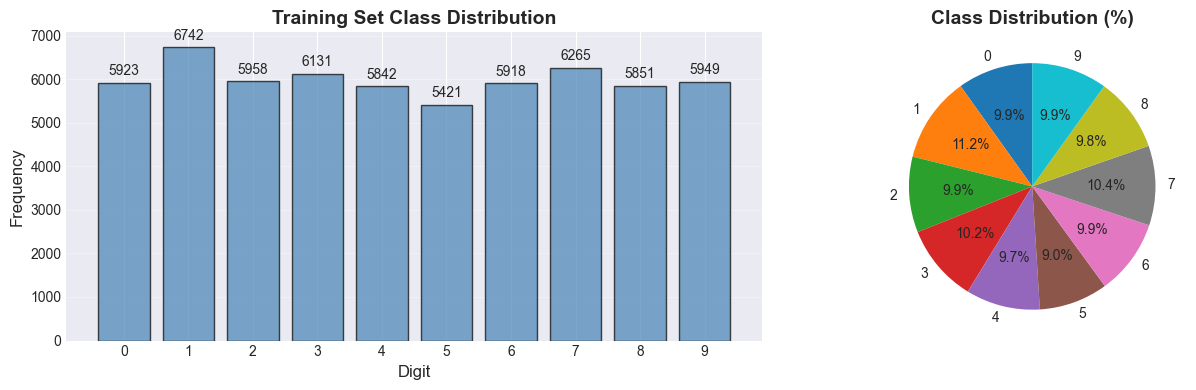

Dataset is well-balanced across all digit classes ✓


In [6]:
# Analyze class distribution
unique, counts = np.unique(y_train, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Bar chart
ax1.bar(unique, counts, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Digit', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xticks(unique)
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (digit, count) in enumerate(zip(unique, counts)):
    ax1.text(digit, count + 100, str(count), ha='center', va='bottom', fontsize=10)

# Pie chart
ax2.pie(counts, labels=unique, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Dataset is well-balanced across all digit classes ✓")

# Data Preprocessing

In [7]:
# Normalize pixel values to [0, 1] range
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape for CNN input (add channel dimension)
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

print(f"Training data shape: {X_train_reshaped.shape}")
print(f"Test data shape: {X_test_reshaped.shape}")
print(f"Normalized pixel range: [{X_train_reshaped.min()}, {X_train_reshaped.max()}]")

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Normalized pixel range: [0.0, 1.0]


# 3. Model Architecture 
# Building an optimized CNN with:
- **2 Convolutional Blocks** with BatchNormalization and Dropout
- **Max Pooling** for dimensionality reduction
- **Dense Layers** with regularization for classification

In [8]:
def build_cnn_model(input_shape: Tuple[int, int, int] = (28, 28, 1)) -> Sequential:
    """
    Build an optimized CNN architecture for MNIST classification.
    
    Architecture:
    - Conv Block 1: 2x Conv2D(32) + MaxPool + Dropout
    - Conv Block 2: 2x Conv2D(64) + MaxPool + Dropout
    - Dense Block: Flatten + Dense(128) + Dropout + Dense(10)
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_1'),
        BatchNormalization(name='bn1_1'),
        Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
        MaxPooling2D((2, 2), name='maxpool1'),
        Dropout(0.25, name='dropout1'),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
        BatchNormalization(name='bn2_1'),
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
        MaxPooling2D((2, 2), name='maxpool2'),
        Dropout(0.25, name='dropout2'),
        
        # Dense layers
        Flatten(name='flatten'),
        Dense(128, activation='relu', name='dense1'),
        BatchNormalization(name='bn3'),
        Dropout(0.5, name='dropout3'),
        Dense(10, activation='softmax', name='output')
    ], name='MNIST_CNN')
    
    # Compile with optimizer and metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
model = build_cnn_model()

# Display model architecture
model.summary()


c:\Users\kwame\anaconda3\envs\model\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,714 (1.79 MB)

 Trainable params: 468,266 (1.79 MB)

 Non-trainable params: 448 (1.75 KB)

# Visualize Model Architecture

In [9]:
# Display model as a diagram
tf.keras.utils.plot_model(
    model, 
    to_file='model_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Total parameters: 468,714
Trainable parameters: 468,266


# 4. Training
# Training configuration:
- **Optimizer:** Adam (learning_rate=0.001)
- **Batch size:** 128
- **Epochs:** 15 (with early stopping)
- **Callbacks:** EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define callbacks for optimal training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
logger.info("Starting model training...")

history = model.fit(
    X_train_reshaped, y_train,
    batch_size=128,
    epochs=15,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

logger.info("Training completed successfully!")

2026-01-05 16:15:33,068 - INFO - Starting model training...


Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.9312 - loss: 0.2287 - val_accuracy: 0.2918 - val_loss: 2.0195 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - accuracy: 0.9791 - loss: 0.0708 - val_accuracy: 0.9898 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.9836 - loss: 0.0541 - val_accuracy: 0.9882 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.9860 - loss: 0.0459 - val_accuracy: 0.9913 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9882 - loss: 0.0365 - val_accuracy: 0.9897 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9884 - loss: 0.0363
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9892 - 

# Training History Visualization

In [ ]:
# Plot training metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
ax1.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
ax1.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.95, 1.0])

# Plot loss
ax2.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=6)
ax2.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

# 5. Evaluation & Visualization

In [ ]:
# Evaluate on test set
logger.info("Evaluating model on test data...")
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=0)

print("=" * 50)
print(f" TEST SET RESULTS")
print("=" * 50)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print("=" * 50)


# Prediction Visualization

In [ ]:
# Visualize predictions on random test samples
num_samples = 20
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image = X_test_reshaped[idx]
    true_label = y_test[idx]
    
    # Make prediction
    predictions = model.predict(image.reshape(1, 28, 28, 1), verbose=0)
    predicted_label = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    
    # Display image
    axes[i].imshow(image.reshape(28, 28), cmap='gray')
    axes[i].axis('off')
    
    # Color code: green for correct, red for incorrect
    color = 'green' if predicted_label == true_label else 'red'
    axes[i].set_title(
        f'Pred: {predicted_label} ({confidence:.1f}%)\nTrue: {true_label}',
        color=color, 
        fontsize=10, 
        fontweight='bold'
    )

plt.suptitle('Model Predictions on Test Data', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions for entire test set
y_pred = np.argmax(model.predict(X_test_reshaped, verbose=0), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - MNIST CNN Classifier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)]))

# Error Analysis: Misclassified Examples

In [ ]:
# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(misclassified_idx)} out of {len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.2f}%)")

if len(misclassified_idx) > 0:
    # Show first 10 misclassifications
    num_errors = min(10, len(misclassified_idx))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for i in range(num_errors):
        idx = misclassified_idx[i]
        image = X_test_reshaped[idx]
        true_label = y_test[idx]
        predicted_label = y_pred[idx]
        
        # Get prediction probabilities
        probs = model.predict(image.reshape(1, 28, 28, 1), verbose=0)[0]
        confidence = probs[predicted_label] * 100
        
        axes[i].imshow(image.reshape(28, 28), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(
            f'Pred: {predicted_label} ({confidence:.1f}%)\nTrue: {true_label}',
            color='red',
            fontsize=10,
            fontweight='bold'
        )
    
    plt.suptitle('Misclassified Examples (Errors to Analyze)', fontsize=16, fontweight='bold', color='red')
    plt.tight_layout()
    plt.show()


# Per-Class Accuracy

In [ ]:
# Calculate per-class accuracy
class_correct = []
class_total = []

for digit in range(10):
    digit_mask = (y_test == digit)
    correct = np.sum((y_pred[digit_mask] == digit))
    total = np.sum(digit_mask)
    class_correct.append(correct)
    class_total.append(total)

class_accuracy = [correct / total * 100 for correct, total in zip(class_correct, class_total)]

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(range(10), class_accuracy, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Digit', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy on Test Set', fontsize=14, fontweight='bold')
plt.xticks(range(10))
plt.ylim([95, 100])
plt.grid(axis='y', alpha=0.3)

# Add accuracy labels on bars
for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print per-class statistics
print("\nPer-Class Statistics:")
print("-" * 50)
for digit in range(10):
    print(f"Digit {digit}: {class_accuracy[digit]:.2f}% ({class_correct[digit]}/{class_total[digit]})")

# Save Model

In [ ]:
# Save the trained model
model_path = 'mnist_cnn_model.keras'
model.save(model_path)
logger.info(f"Model saved to {model_path}")

print(f"\n Model successfully saved to: {model_path}")
print(f"Model size: {np.round(model.count_params() * 4 / 1024**2, 2)} MB")